In [1]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/red_pill_analises/'

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as pd
import pandas as pd
import seaborn as sns


In [3]:
df_channels = pd.read_csv(folder_path + 'data_base/dados_coletados_por_query/channels_info.csv')
df_videos = pd.read_csv(folder_path + 'data_base/dados_coletados_por_query/videos_info.csv')
df_comments = pd.read_csv(folder_path + 'data_base/dados_coletados_por_query/comments_info.csv')

# Anotações iniciais

- o código não procurava na descrição, então alterei para começar a procurar (inclusive os links)
- não consegui fazer procurar no comentário, pois pelo que pesquisei a API não consegue identificar um comentário fixado. Tentei procurar as palavras no dois primeiros comentários, mas o código passou a dar um erro que não consegui resolver. Como já estava recolhendo de título e descrição, resolvi deixar do jeito que estava.

# Dimensões e compreensões iniciais

In [4]:
df_comments.shape

(1224057, 15)

In [5]:
df_comments.columns

Index(['video_id', 'comment_id', 'author', 'author_profile_image_url',
       'author_channel_url', 'author_channel_id', 'comment', 'published_at',
       'updated_at', 'like_count', 'viewer_rating', 'can_rate', 'is_reply',
       'parent_id', 'channel_id'],
      dtype='object')

In [6]:
df_comments.groupby('author').size().sort_values(ascending=False).shape

(757574,)

In [7]:
df_videos.shape

(4158, 35)

In [8]:
# Supondo que a coluna com o identificador se chama 'id'
# Se o nome for outro, como 'channel_id', basta trocar no subset.

# O parâmetro 'subset' diz ao pandas para olhar apenas para a coluna 'id'
# para identificar as duplicatas.
df_channels_unicos = df_channels.drop_duplicates(subset=['channel_id'])

df_channels_unicos.shape

(2444, 12)

# Popularidade

In [9]:
import matplotlib.pyplot as plt
from collections import Counter

def plotar_popularidade(dados: dict, titulo: str = "Popularidade - Vídeos por Canal", cor: str = "steelblue", eixoX='Quantidade de Vídeos', eixoY='Número de Canais'):
    """
    Plota a distribuição de popularidade: número de canais com exatamente N vídeos.

    @param dados: Dicionário {canal_id: quantidade_videos}.
    """
    if not dados:
        print("Nenhum dado fornecido.")
        return

    # Contar quantos canais têm exatamente cada quantidade de vídeos
    contagem = Counter(dados.values())

    # Ordenar os dados pelo número de vídeos
    x = sorted(contagem.keys())
    y = [contagem[v] for v in x]

    # Plotar
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', linestyle='-', color=cor)
    plt.xlabel(eixoX)
    plt.ylabel(eixoY)
    plt.title(titulo)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [10]:
# Agrupar e contar vídeos por canal
quant_videos_canais = df_channels.groupby('channel_id').size().reset_index(name='quantidade_videos')

# Converter para dicionário
dict_videos = dict(zip(quant_videos_canais['channel_id'], quant_videos_canais['quantidade_videos']))




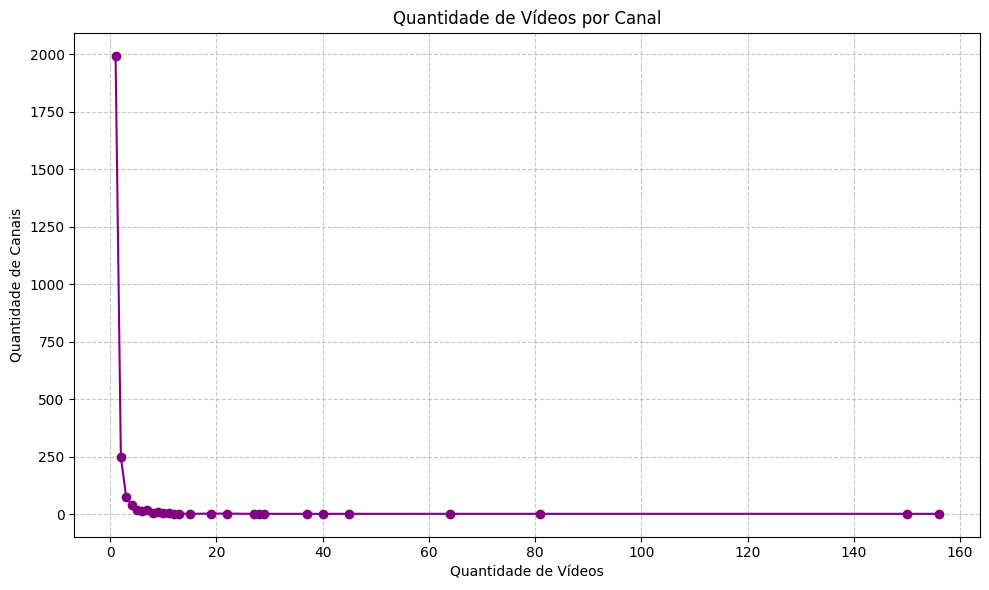

In [11]:
# Usar na função de gráfico
plotar_popularidade(dados = dict_videos, titulo="Quantidade de Vídeos por Canal", cor='purple',eixoX = 'Quantidade de Vídeos', eixoY = 'Quantidade de Canais')

# De onde devemos tirar mais vídeos?

In [12]:
df_channels.columns

Index(['channel_id', 'title', 'description', 'published_at', 'country',
       'view_count', 'comment_count', 'subscriber_count', 'video_count',
       'is_verified', 'keywords', 'profile_picture_url'],
      dtype='object')

In [13]:
top10 = (
    df_channels
    .groupby('channel_id')
    .size()
    .reset_index(name='quantidade_videos')
    .sort_values(by='quantidade_videos', ascending=False)
    .head(10)
)
df_top10 = df_channels.merge(top10, on='channel_id').drop_duplicates(subset='channel_id')[['channel_id', 'title', 'quantidade_videos']]
df_top10

,channel_id,title,quantidade_videos
0,UCOmgZM9a03QjICfkCaxcjYA,Red Pill Podcast,156
6,UCLSS8MFT4MxDy1sSE1vlDiA,Coach Paz Goldman,28
8,UCdVVI9mJUzGWShsD80poZMg,Fabrício Acunha Mentor,40
17,UCRmNflJuD1TxLbRlDV08_7g,Consciência Masculina,150
20,UCUBeVY6Kn7ulBmUGynJqISw,Highlander o último redpill!,81
42,UCpeW2LVGeNLnSXCp64b3TEQ,Império AntiOtário,64
43,UCeolohk2oA6_gQR0SLgGyhQ,Relacje z kobietami,45
239,UCJo6X9hXPvweXa7ZviWKO2A,Ajuda Mental,37
246,UCHd4aYsPUbXB3lnS2O_RpPw,Locutor Maromba,27
575,UCwkhscWOa5gDDQ0R1f_rY_A,Q&A Amorim,29


In [18]:
# outros canais que não aparecem ali podem ser conhecidos (análise empírica) como canais redPill
# analisando...

# 1. Canais com menos de 5 vídeos (irrelevantes)
aux = df_channels.groupby('channel_id').size().reset_index(name='quantidade_videos')
df_channels_irrelevant = aux[(aux['quantidade_videos'] < 5)]

# 2. Canais BR
df_channels_br = df_channels_unicos[df_channels_unicos['country'] == 'BR']

# 3. Filtrar canais BR que NÃO estejam na lista de irrelevantes
# Criar uma lista (ou set) de channel_id irrelevantes para filtro
irrelevantes_ids = set(df_channels_irrelevant['channel_id'])

# Filtrar canais BR cujo channel_id NÃO está em irrelevantes_ids
df_channels_br_relevantes = df_channels_br[~df_channels_br['channel_id'].isin(irrelevantes_ids)]

# Agora, se quiser acessar os títulos desses canais:
titulos = df_channels_br_relevantes[~df_channels_br_relevantes['channel_id'].isin(top10['channel_id'])][['title','channel_id']].reset_index()
titulos

,index,title,channel_id
0,5,AuriVerde Brasil,UCLHIUIBIid6qpljFBWEOHSw
1,15,RedCast [Oficial],UCeL1a4rpEA8UG9IQIewPccg
2,77,Geração AntiOtário,UCAYoI16-UkXemcnhC-kTvDQ
3,126,Thiago Schutz (Oficial),UCfx6e_bcnSL0aMDVx0xSlPw
4,152,Sigma da Solitude,UCExFA9MsrRmWnXUlhiwu4qA
5,183,Projeto Conselho,UCX0VSzJ2z5l0C9wnwh5SoRw
6,207,Don Sandro,UC3nQ4xUl6rodOWuQbBULyow
7,251,Red Pill Feminina,UCO9FRrBUwGdYopkMbGGKbpg
8,294,Cortes do Inteligência [OFICIAL],UCvmWNQH4c2T3Triih3lftiw
9,356,Cortes do Boltz [OFICIAL],UCTsZZ6zg9xTev8W5diPEOJA


In [36]:
# Conhecidos anteriomente que não estão entre os com mais de 5 vídeos
proeminentes_red_pill = ['UCI8GhdRx2zMoAlg-NvwRLog', 'UCDrGZXd8k06ifz0-gccIn0w', 'UCZLKzB_7kUljL-A4TojxMmQ'
                        'UCCqPJ9sE7QQ1QUxTB4YiflA', 'UCYWqR3u-h0hiSARo0KyYl7g	', 'UCNiU1wZxK6YN-KuJP7QMpBQ']

# Análise empírica, remoção e adição de canais

Pesquisei o nome de todos os canais do top 10 no youtube para ver se estavam de acordo. Procurei também por todos os canais brasileiros com mais de 5 vídeos coletados. Esses foram os resultados:

## ❌ Não são RedPill (no top10)
Coach Paz Goldman: fala sobre relacionamentos, mas aparentemente não deprecia mulheres. Porém, o principal motivo para tirar do foco é que não é br

Psychologia Kobiety: é de uma psicóloga turca (não é em português)

Ajuda Mental: sem menções a termos redpill nos primeiros vídeos (muito provavelmente foi coletado um conteúdo isolado)



## 💊 São RedPill
Analisei todos os 43 canais resultantes da pesquisa de canais brasileiros com masi de 5 vídeos coletados. A análise se deu pela pesquisa do id no canal do Youtube, de maneira não automatizada.
Para saber se são redPill:
1. Pesquisa manual dos nomes no youtube
2. Mesmo que o título não seja rastreado pelas palavras chaves, a imagem de thumb muitas vezes denuncia
3. Caso não apareçam pontos técnicos, o autor do canal é um conhecido da comunidade, o que foi perceptível por análise sobre a comunidade.
4. Canais com TODOS os primeiros vídeos ou a descrição claramente RedPill ou afins (diferentes temas em um mesmo canal podem gerar lixo demais nesse caso)

## Comentário
- Todos os canais 'Antiotário' são no mesmo formato, com a mesma pessoa.
- Karine Floriana apresenta dicas de relacionamentos para mulheres com uma visão bem red pill

In [37]:
canais_finais =['UCI8GhdRx2zMoAlg-NvwRLog',
 'UCpz_R2L_jolO-RG0V_KvyPQ',
 'UCdVVI9mJUzGWShsD80poZMg',
 'UCpeW2LVGeNLnSXCp64b3TEQ',
 'UCRmNflJuD1TxLbRlDV08_7g',
 'UCX0VSzJ2z5l0C9wnwh5SoRw',
 'UC3nQ4xUl6rodOWuQbBULyow',
 'UCfx6e_bcnSL0aMDVx0xSlPw',
 'UCDrGZXd8k06ifz0-gccIn0w',
 'UCoigiav3LDJJkt2SiXKxUaQ',
 'UCZLKzB_7kUljL-A4TojxMmQ',
 'UCUBeVY6Kn7ulBmUGynJqISw',
 'UCeL1a4rpEA8UG9IQIewPccg',
 'UCGPyMhoHjh3EyKUHuiNq0jA',
 'UCAYoI16-UkXemcnhC-kTvDQ',
 'UC1uQ9bGrXnbm27oSoRY1hOQ',
 'UCCqPJ9sE7QQ1QUxTB4YiflA',
 'UCSpUAJw93VIHVn8k-JP8NTQ',
 'UCeO2AubeXjuOfRcyZs_rIIA',
 'UCwkhscWOa5gDDQ0R1f_rY_A',
 'UCQDsVQO2-Lju8iDu3k_k-bw',
 'UCwC0gjZzYXopNGdXveEUS4A',
 'UCO9FRrBUwGdYopkMbGGKbpg',
 'UCYWqR3u-h0hiSARo0KyYl7g',
 'UC2mYg5TZ092oVhh66-9AYUA',
 'UCNiU1wZxK6YN-KuJP7QMpBQ',
 'UCExFA9MsrRmWnXUlhiwu4qA',
 'UC5jojOrPlt_4MwesFoI9p6A']

In [38]:
len(canais_finais)

28

## Processo de coleta
Foram selecionados, primeiramente, os top 10 canais com mais vídeos coletados pela coleta inicial (palavras chaves). Esses canais foram analisados empiricamente para o entendimento de quais eram realmente redPill. Então, filtrou-se pela coluna country os canais com a denominação de BR, para manter apenas os brasileiros. Para uma adição de mais canais, foram acrescentados na lista canais conhecidamente (pelos pesquisadores) como influenciadores redPill, além de uma análise de canais br com mais de 5 videos coletados: se os 6 primeiros vídeos ou a descrição apresentasse temas e conceitos red pill, o id do canal foi adicionado a lista. A partir dessa lista, foi realizada a nova coleta: todos os videos de 1 de jan de 2024 a 25 de mai de 2025 de todos os canais selecionados.

A coleta é feita da seguinte forma: a partir do id, o script faz uma requisição usando uma chave API da propria plataforma. Essa chave retorna no maximo 50 videos por requisição. Cada requisição usa um pouco da cota da API, que tem cota, geralmente de 10000 (confirmar quanto da cota é utilizado para esse tipo de requisição). Então, usando 12 chaves de API diferentes, são feitas várias requisições até que se colete todos os videos (o script caminha mes a mes, para dividir a coleta de maneira eficiente).